# Capstone Project - Week 2

## Grouping Cities for Fast Food Chain

### Table of contents
* [Introduction](#intro)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

### Introduction <a name = "intro"></a>

In this project, we will try to **cluster cities in USA based on existing food outlets**. Once done, it will help us analyse cities and determine what kind of food items suits best for the customers in those cities.

### Data <a name = "data"></a>

For our problem, we need
* List of cities
* List of restaurants in those area and their categories

Importing all the necessary libraries

In [1]:
import pandas as pd
import requests
import json
import folium

In [2]:
import numpy as np

In [3]:
from sklearn import preprocessing

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [5]:
from sklearn.cluster import KMeans

Getting a Table for top 100 cities by population

In [6]:
city_list = pd.read_html("https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population")[4][1:101].drop([0,2,3,4,5,6,7,8,9,10], axis=1)


In [7]:
city_list.columns = ['Name']
city_list['Name'] = city_list['Name'].apply(lambda name: name.split('[')[0])
city_list.head()

,Name
1,New York City
2,Los Angeles
3,Chicago
4,Houston
5,Phoenix


City of 'Winston-Salem' returns error code : 400 later in the program. To avoid that I am replacing it with workable string

In [8]:
city_list['Name'].iloc[89] = 'Winston Salem'

##### Defining our final dataframe

In [9]:
df = pd.DataFrame()
df['City'] = city_list['Name']

In [10]:
listofcities = city_list['Name'].tolist()

##### Adding Foursquare Credentials

In [11]:
CLIENT_ID = 'VKLKIMWANBBPGNKVIVJRWDULSQVKVYPNLDJQRSXTKKXP4AJC' # your Foursquare ID
CLIENT_SECRET = 'EOCWZQHWY3K3CKJ1FWPEEAPSLSN0M4AVRQALPDEIKJJBKOQU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 50 # A default Foursquare API limit value


#### Examples of cities

It is important to note that in foursquare API, when the radius of the query is not specified, it will automatically select the radius based on how dense the area is or official map. Here are some examples to confirm it.

In [12]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="capstoneProject")

In [13]:
def getVenuesByCity(cityName):
    url = 'https://api.foursquare.com/v2/venues/explore?near={}&section=food&day=any&time=any&limit={}&client_id={}&client_secret={}&v={}'.format(
        cityName,
        LIMIT,
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION)
    
    results = requests.get(url).json()
    allVenues = results['response']['groups'][0]['items']
    totalResults = results['response']['totalResults']
    OFFSET = 50
    while(OFFSET<totalResults):
        url = 'https://api.foursquare.com/v2/venues/explore?near={}&section=food&day=any&time=any&limit={}&offset={}&client_id={}&client_secret={}&v={}'.format(
            cityName,
            LIMIT,
            OFFSET,
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION)
        OFFSET +=50
        allVenues += requests.get(url).json()['response']['groups'][0]['items']
    return allVenues

# Locations Visulised
Here are some random examples that shows how density of venues decreases as you move out of the center. After exploring some example, it is confirmed that the area covered by venues given lines up perfectly with official maps of the city. Downside to this approach is that in case of large city, neighboring areas of the city may get ignored, which is not always the best choice but, the data will still be very useful as it gives a sample of what kind of food venues are present in the city. Considering that data for 100 cities is needed, this seems to be appropiate approach.

In [14]:
def mapCity(city):
    city_Results = getVenuesByCity(city)
    location = geolocator.geocode(city)
    
    Latitude, Longitude = location.latitude, location.longitude
    map_city = folium.Map(location=[Latitude,Longitude],zoom_start=13)

    for i in range(len(city_Results)):
        lat = city_Results[i]['venue']['location']['lat']
        lng = city_Results[i]['venue']['location']['lng']
        label = city_Results[i]['venue']['categories'][0]['name']
        label = folium.Popup(label, parse_html=True)

        folium.CircleMarker([lat, lng],
                            popup=label,
                            radius=5,
                            color='#D2691E',
                            fill=True,
                            fill_color='#D2691E',
                            fill_opacity=0.3).add_to(map_city)

    return map_city

##### San Francisco

In [15]:
mapCity('San Francisco')

##### Charleston

In [16]:
mapCity('Charleston')

##### Los Angeles

In [17]:
mapCity('Los Angeles')

#### Function that adds number of restaurants of perticular categories
This function will take name of the city as an input and using json data recieved from foursquare places API, it will convert it into a row of counts of venues belonging to different categories.

In [18]:
def addCatsByCity(cityName):
    url = 'https://api.foursquare.com/v2/venues/explore?near={}&section=food&day=any&time=any&limit={}&client_id={}&client_secret={}&v={}'.format(
        cityName,
        LIMIT,
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION)
    
    results = requests.get(url).json()
    
    if results['meta']['code']!=200:
        return None
    
    firstPage = nextPage = results['response']['groups'][0]['items']
    for i in range(50):
        cat = firstPage[i]['venue']['categories'][0]['name']
        if cat in df.columns:
            df.loc[df.City == cityName, cat] += 1
        else:
            df[cat]=[0]*len(df)
            df.loc[df.City == cityName, cat] += 1
    
    totalResults = results['response']['totalResults']
    OFFSET = 50
    while(OFFSET<totalResults):
        url = 'https://api.foursquare.com/v2/venues/explore?near={}&section=food&day=any&time=any&limit={}&offset={}&client_id={}&client_secret={}&v={}'.format(
            cityName,
            LIMIT,
            OFFSET,
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION)
        nextPage = requests.get(url).json()['response']['groups'][0]['items']
        for item in nextPage:
            cat = item['venue']['categories'][0]['name']
            if cat in df.columns:
                df.loc[df.City == cityName, cat] += 1
            else:
                df[cat]=[0]*len(df)
                df.loc[df.City == cityName, cat] += 1
        OFFSET +=50
    return None

In [19]:
for city in listofcities:
    addCatsByCity(city)

Final DataFrame

In [20]:
df.head()

,City,Restaurant,Bakery,Taco Place,Steakhouse,Thai Restaurant,Seafood Restaurant,Sandwich Place,New American Restaurant,Israeli Restaurant,...,Grilled Meat Restaurant,Caucasian Restaurant,Pelmeni House,Blini House,Colombian Restaurant,Shanghai Restaurant,Cantonese Restaurant,Trattoria/Osteria,Poutine Place,Salvadoran Restaurant
1,New York City,3,14,4,2,9,8,8,10,1,...,0,0,0,0,0,0,0,0,0,0
2,Los Angeles,8,12,7,4,0,7,13,12,0,...,0,0,0,0,0,0,0,0,0,0
3,Chicago,7,7,5,6,0,5,9,16,1,...,0,0,0,0,0,0,0,0,0,0
4,Houston,3,4,5,8,2,6,6,7,0,...,0,0,0,0,0,0,0,0,0,0
5,Phoenix,4,2,5,7,2,4,3,7,0,...,0,0,0,0,0,0,0,0,0,0


Exporting Dataframe for safety

In [21]:
df.to_csv('templist.csv')

##### Checking if any of city has 0 results

In [22]:
df.loc[df.sum(axis=1)==0]

,City,Restaurant,Bakery,Taco Place,Steakhouse,Thai Restaurant,Seafood Restaurant,Sandwich Place,New American Restaurant,Israeli Restaurant,...,Grilled Meat Restaurant,Caucasian Restaurant,Pelmeni House,Blini House,Colombian Restaurant,Shanghai Restaurant,Cantonese Restaurant,Trattoria/Osteria,Poutine Place,Salvadoran Restaurant


Some cities may not gave any result, in that case let's manually check for these cities

In [23]:
#formula for url
for i in []:
    url = 'https://api.foursquare.com/v2/venues/explore?near={}&section=food&day=any&time=any&limit={}&client_id={}&client_secret={}&v={}'.format(
            df['City'].iloc[i],
            LIMIT,
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION)
    result = requests.get(url).json()
    if result['meta']['code']!=200:
        print("error getting results for {}".format(df['City'].iloc[i]))
        print (result['meta'])
        continue
    print("Total results for {}: ".format(df['City'].iloc[i]) , result['response']['totalResults'])


Reading the pre-saved dataframe incase there was a problem with API

In [24]:
df = pd.read_csv('templist.csv')
df = df.drop(df.columns[0], axis=1)
df.head()

,City,Restaurant,Bakery,Taco Place,Steakhouse,Thai Restaurant,Seafood Restaurant,Sandwich Place,New American Restaurant,Israeli Restaurant,...,Grilled Meat Restaurant,Caucasian Restaurant,Pelmeni House,Blini House,Colombian Restaurant,Shanghai Restaurant,Cantonese Restaurant,Trattoria/Osteria,Poutine Place,Salvadoran Restaurant
0,New York City,3,14,4,2,9,8,8,10,1,...,0,0,0,0,0,0,0,0,0,0
1,Los Angeles,8,12,7,4,0,7,13,12,0,...,0,0,0,0,0,0,0,0,0,0
2,Chicago,7,7,5,6,0,5,9,16,1,...,0,0,0,0,0,0,0,0,0,0
3,Houston,3,4,5,8,2,6,6,7,0,...,0,0,0,0,0,0,0,0,0,0
4,Phoenix,4,2,5,7,2,4,3,7,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
df.shape

(100, 136)

In [26]:
df.head()

,City,Restaurant,Bakery,Taco Place,Steakhouse,Thai Restaurant,Seafood Restaurant,Sandwich Place,New American Restaurant,Israeli Restaurant,...,Grilled Meat Restaurant,Caucasian Restaurant,Pelmeni House,Blini House,Colombian Restaurant,Shanghai Restaurant,Cantonese Restaurant,Trattoria/Osteria,Poutine Place,Salvadoran Restaurant
0,New York City,3,14,4,2,9,8,8,10,1,...,0,0,0,0,0,0,0,0,0,0
1,Los Angeles,8,12,7,4,0,7,13,12,0,...,0,0,0,0,0,0,0,0,0,0
2,Chicago,7,7,5,6,0,5,9,16,1,...,0,0,0,0,0,0,0,0,0,0
3,Houston,3,4,5,8,2,6,6,7,0,...,0,0,0,0,0,0,0,0,0,0
4,Phoenix,4,2,5,7,2,4,3,7,0,...,0,0,0,0,0,0,0,0,0,0


This final table concludes the data section.

### Methodology <a name = "methodology"></a>

Analysing all data

types of restuarants and their numbers across all analysed cities.

In [27]:
df.iloc[:,1:].sum(axis=0).sort_values(ascending=False)

Mexican Restaurant           1299
Pizza Place                  1074
American Restaurant          1072
Italian Restaurant            734
Burger Joint                  640
Bakery                        622
Sandwich Place                607
Fast Food Restaurant          492
Seafood Restaurant            479
Breakfast Spot                479
Café                          466
Steakhouse                    421
Sushi Restaurant              381
BBQ Joint                     362
Restaurant                    356
New American Restaurant       338
Chinese Restaurant            267
Thai Restaurant               249
Vietnamese Restaurant         247
Deli / Bodega                 236
Japanese Restaurant           228
Taco Place                    228
Mediterranean Restaurant      222
Donut Shop                    210
Asian Restaurant              199
Fried Chicken Joint           193
Diner                         184
Gastropub                     178
French Restaurant             164
Food Truck    

Plotting venues per city

Text(0, 0.5, 'Number of restaurants in a city')

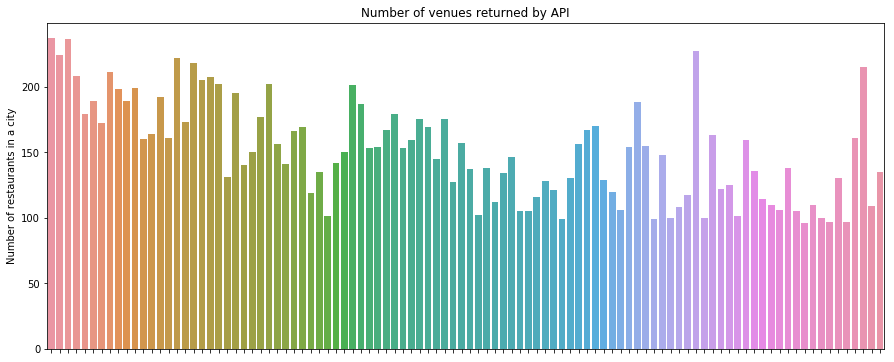

In [28]:
countlist = df.iloc[:,1:].sum(axis=1)
    
plt.figure(figsize=(15,6))
plt.title("Number of venues returned by API")

g = sns.barplot(x=df.index, y=countlist)
                 
g.set(xticklabels=[])

plt.ylabel("Number of restaurants in a city")

Plotting most common first 50 categories

In [29]:
total_res = df.iloc[:,1:].sum(axis=0).sort_values(ascending=False)[:50]

Text(0, 0.5, 'Number of total restaurants')

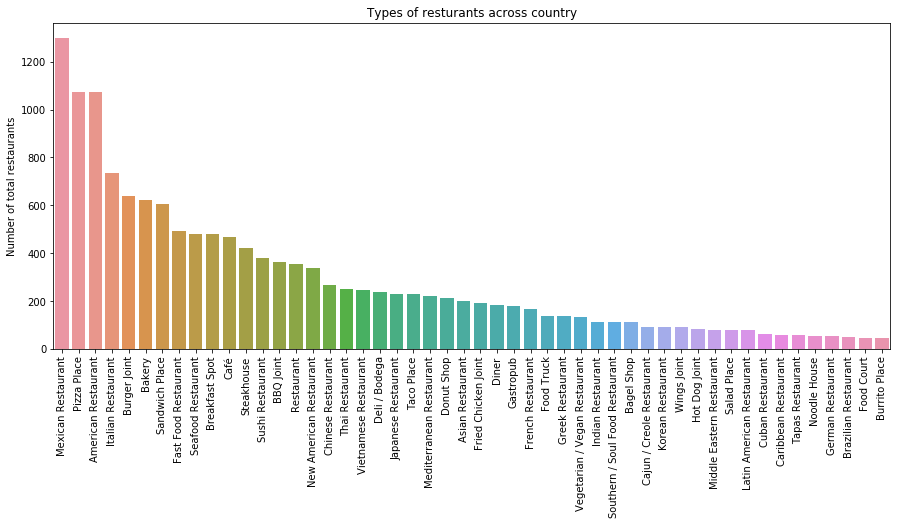

In [30]:
plt.figure(figsize=(15,6))
plt.title("Types of resturants across country")

sns.barplot(x=total_res.index, y=total_res)
plt.xticks(rotation=90)

plt.ylabel("Number of total restaurants")

Pie chart for categories and number of cities they are number 1 in

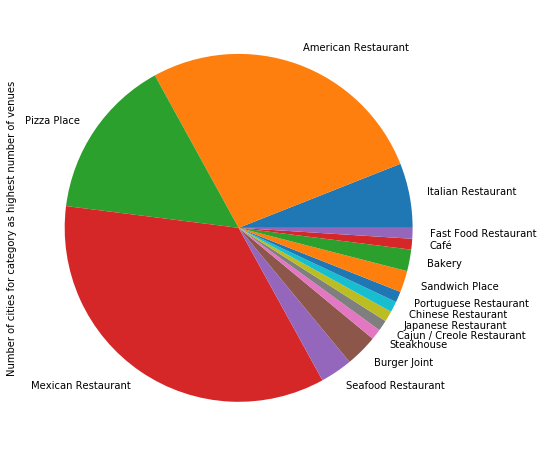

In [45]:
cluster_data = df
cluster_data['maxID'] = cluster_data.drop('City',axis=1).idxmax(axis=1)
group_df = pd.DataFrame()
for i in range(len(cluster_data)):
    type = cluster_data['maxID'].iloc[i]
    if type in group_df.columns:
        group_df[type].iloc[i] = cluster_data['City'].iloc[i]
    else:
        group_df[type] = [None]*len(cluster_data)
        group_df[type].iloc[i] = cluster_data['City'].iloc[i]
            
count = group_df.count()
plot = count.plot.pie(y=count, figsize=(8,8))
plt.ylabel('Number of cities for category as highest number of venues')
plt.show()

In [46]:
count

Italian Restaurant            6
American Restaurant          27
Pizza Place                  15
Mexican Restaurant           35
Seafood Restaurant            3
Burger Joint                  3
Steakhouse                    1
Cajun / Creole Restaurant     1
Japanese Restaurant           1
Chinese Restaurant            1
Portuguese Restaurant         1
Sandwich Place                2
Bakery                        2
Café                          1
Fast Food Restaurant          1
dtype: int64

Normalising Dataset

In [31]:
x = df.iloc[:,1:].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_norm = pd.DataFrame(x_scaled)
df_norm.columns = df.columns[1:]
df_norm.head()

C:\Users\Bhavya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,Restaurant,Bakery,Taco Place,Steakhouse,Thai Restaurant,Seafood Restaurant,Sandwich Place,New American Restaurant,Israeli Restaurant,American Restaurant,...,Grilled Meat Restaurant,Caucasian Restaurant,Pelmeni House,Blini House,Colombian Restaurant,Shanghai Restaurant,Cantonese Restaurant,Trattoria/Osteria,Poutine Place,Salvadoran Restaurant
0,0.12,0.302326,0.307692,0.133333,0.9,0.363636,0.533333,0.6250,0.333333,0.384615,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.32,0.255814,0.538462,0.266667,0.0,0.318182,0.866667,0.7500,0.000000,0.538462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.28,0.139535,0.384615,0.400000,0.0,0.227273,0.600000,1.0000,0.333333,0.307692,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.12,0.069767,0.384615,0.533333,0.2,0.272727,0.400000,0.4375,0.000000,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.16,0.023256,0.384615,0.466667,0.2,0.181818,0.200000,0.4375,0.000000,0.423077,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Clustering Cities

In [32]:
#number of clusters
nclusters = 4
df_clustering = df_norm
kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(df_clustering)

len(kmeans.labels_)

100

In [33]:
df_clustered = df
df_clustered['Cluster'] = kmeans.labels_
df_clustered.head()

,City,Restaurant,Bakery,Taco Place,Steakhouse,Thai Restaurant,Seafood Restaurant,Sandwich Place,New American Restaurant,Israeli Restaurant,...,Caucasian Restaurant,Pelmeni House,Blini House,Colombian Restaurant,Shanghai Restaurant,Cantonese Restaurant,Trattoria/Osteria,Poutine Place,Salvadoran Restaurant,Cluster
0,New York City,3,14,4,2,9,8,8,10,1,...,0,0,0,0,0,0,0,0,0,3
1,Los Angeles,8,12,7,4,0,7,13,12,0,...,0,0,0,0,0,0,0,0,0,3
2,Chicago,7,7,5,6,0,5,9,16,1,...,0,0,0,0,0,0,0,0,0,3
3,Houston,3,4,5,8,2,6,6,7,0,...,0,0,0,0,0,0,0,0,0,2
4,Phoenix,4,2,5,7,2,4,3,7,0,...,0,0,0,0,0,0,0,0,0,1


### Results and Discussion <a name = "results"></a>

In [34]:
unique_elements, counts_elements = np.unique(kmeans.labels_, return_counts=True)
print("number of cities in each cluster:")
print(np.asarray((unique_elements, counts_elements)))

number of cities in each cluster:
[[ 0  1  2  3]
 [39 38 13 10]]


Making a differnet dataframe for each cluster

In [35]:
df_c0 = df_clustered.loc[df_clustered['Cluster']==0]
df_c0.head()

,City,Restaurant,Bakery,Taco Place,Steakhouse,Thai Restaurant,Seafood Restaurant,Sandwich Place,New American Restaurant,Israeli Restaurant,...,Caucasian Restaurant,Pelmeni House,Blini House,Colombian Restaurant,Shanghai Restaurant,Cantonese Restaurant,Trattoria/Osteria,Poutine Place,Salvadoran Restaurant,Cluster
11,Jacksonville,6,4,1,4,4,6,12,1,0,...,0,0,0,0,0,0,0,0,0,0
12,Fort Worth,4,3,5,8,5,6,6,6,0,...,0,0,0,0,0,0,0,0,0,0
21,El Paso,1,7,4,5,1,3,3,0,0,...,0,0,0,0,0,0,0,0,0,0
31,Albuquerque,1,4,3,4,2,2,4,0,0,...,0,0,0,0,0,0,0,0,0,0
32,Tucson,1,3,2,4,1,1,9,2,0,...,0,0,0,0,0,0,0,0,0,0


#### Plotting graphs for most common types of restaurants in each cluster

In [36]:
def plotCluster(cID):
    cluster_data = df_clustered.loc[df_clustered['Cluster']==cID]
    total_vens = cluster_data.iloc[:,1:-1].sum(axis=0).sort_values(ascending=False)[:50]
    #print(cluster_data['City'])
    #plotting
    plt.figure(figsize=(15,6))
    plt.title("Types of resturants in cluster {}".format(cID))
    sns.barplot(x=total_vens.index, y=total_vens)
    plt.xticks(rotation=90)
    plt.ylabel("Number of total restaurants in cluster {}".format(cID))
    plt.show()

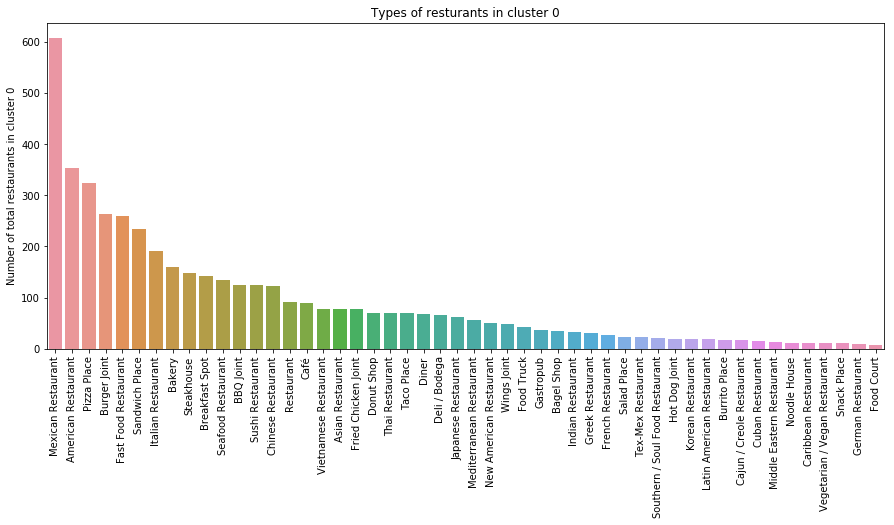

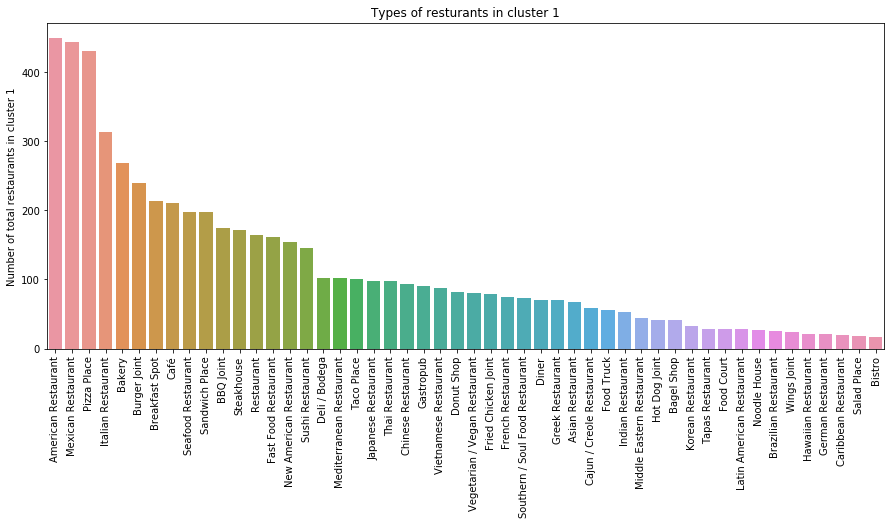

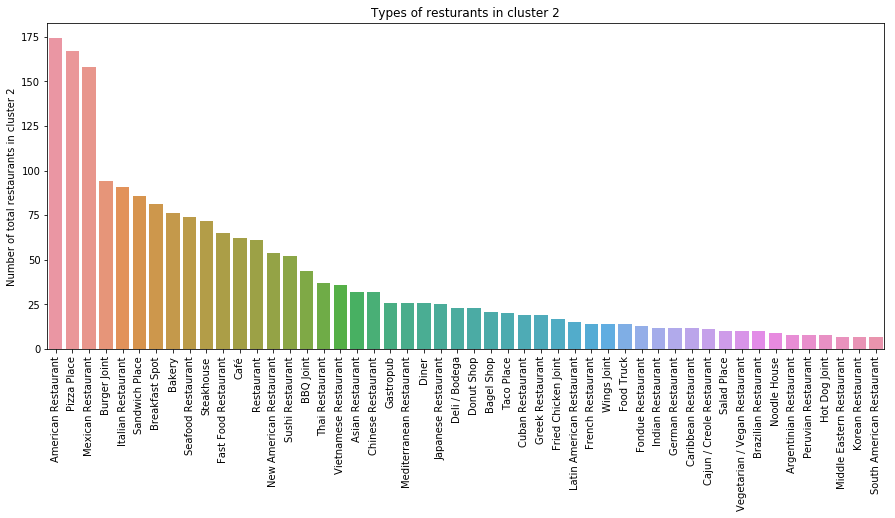

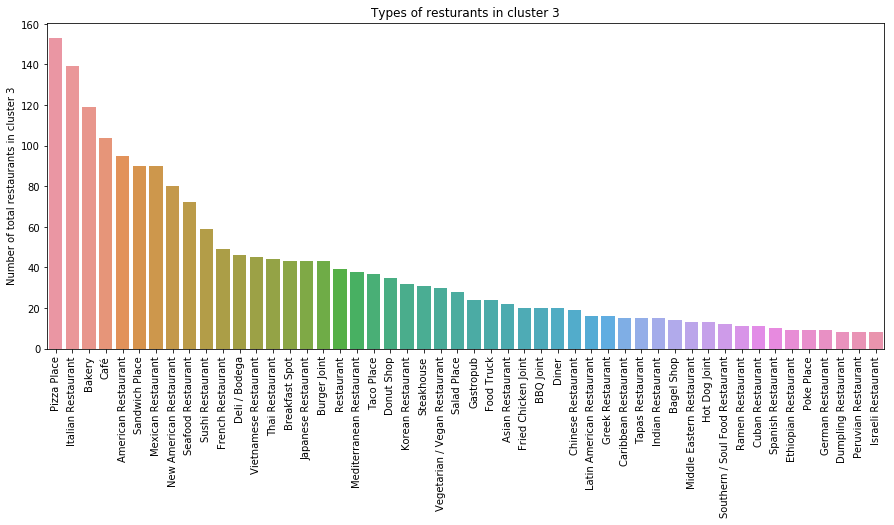

In [37]:
for i in range(nclusters):
    plotCluster(i)

#### Grouping cities by its most common category of food place.

In [38]:
def sortCities(cID):
    print("Cluster number: {}".format(cID))
    cluster_data = df_clustered.loc[df_clustered['Cluster']==cID]
    cluster_data['maxID'] = cluster_data.drop('City',axis=1).idxmax(axis=1)
    group_df = pd.DataFrame()
    for i in range(len(cluster_data)):
        type = cluster_data['maxID'].iloc[i]
        if type in group_df.columns:
            group_df[type].iloc[i] = cluster_data['City'].iloc[i]
        else:
            group_df[type] = [None]*len(cluster_data)
            group_df[type].iloc[i] = cluster_data['City'].iloc[i]
    
    for column in group_df.columns:
        print(column)
        for i in range(len(group_df)):
            if group_df[column].iloc[i] != None:
                print(group_df[column].iloc[i])
        
        print('\n')
    print("----------------------------------------------")
    
   

In [39]:
for i in range(nclusters):
    sortCities(i)

Cluster number: 0
American Restaurant
Jacksonville
Arlington
Lexington
Toledo
Reno
Winston Salem


Mexican Restaurant
Fort Worth
El Paso
Albuquerque
Tucson
Fresno
Mesa
Sacramento
Wichita
Bakersfield
Aurora
Santa Ana
Riverside
Stockton
Greensboro
Anchorage
Plano
Chula Vista
Fort Wayne
Laredo
Chandler
Lubbock
Chesapeake
Garland
Irving


Pizza Place
Omaha
Gilbert


Burger Joint
Tulsa
Corpus Christi


Italian Restaurant
Henderson


Chinese Restaurant
Lincoln


Fast Food Restaurant
North Las Vegas


Sandwich Place
Norfolk


Bakery
Hialeah


----------------------------------------------
Cluster number: 1


C:\Users\Bhavya\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Mexican Restaurant
Phoenix
San Antonio
Dallas
San Jose
Denver
Milwaukee
Long Beach
Anaheim
Scottsdale


Seafood Restaurant
San Diego
Baton Rouge


Pizza Place
Austin
Columbus
Baltimore
Atlanta
St. Louis
Fremont


American Restaurant
Charlotte
Nashville
Detroit
Memphis
Louisville
Kansas City
Raleigh
Minneapolis
Saint Paul
Pittsburgh
Irvine
Buffalo
Richmond


Steakhouse
Las Vegas


Cajun / Creole Restaurant
New Orleans


Italian Restaurant
Cleveland


Japanese Restaurant
Honolulu


Portuguese Restaurant
Newark


Sandwich Place
Durham


Bakery
St. Petersburg


Café
Jersey City


----------------------------------------------
Cluster number: 2
Mexican Restaurant
Houston


American Restaurant
Indianapolis
Colorado Springs
Tampa
Cincinnati
Orlando
Madison
Spokane


Burger Joint
Oklahoma City


Italian Restaurant
Miami


Seafood Restaurant
Virginia Beach


Pizza Place
Glendale
Boise


----------------------------------------------
Cluster number: 3
Italian Restaurant
New York City
Seattle
Bos

Explaination:
     This graphs will show number of cities with most common categories. For example, in cluster 0, there are 7 cities that has more number of american restaurants than any other types of restaurant, then it will plot bar of height 7.

In [40]:
def graphClusters(cID):
    cluster_data = df_clustered.loc[df_clustered['Cluster']==cID]
    cluster_data['maxID'] = cluster_data.drop('City',axis=1).idxmax(axis=1)
    group_df = pd.DataFrame()
    for i in range(len(cluster_data)):
        type = cluster_data['maxID'].iloc[i]
        if type in group_df.columns:
            group_df[type].iloc[i] = cluster_data['City'].iloc[i]
        else:
            group_df[type] = [None]*len(cluster_data)
            group_df[type].iloc[i] = cluster_data['City'].iloc[i]
            
    count = group_df.count()
    plt.figure(figsize=(15,6))
    plt.title("Categories being most common in the cities in cluster {}".format(cID))
    sns.barplot(x=count.index, y=count)
    plt.xticks(rotation=90)
    plt.xlabel('Categories')
    plt.ylabel("Number of cities {}".format(cID))
    plt.show()

C:\Users\Bhavya\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


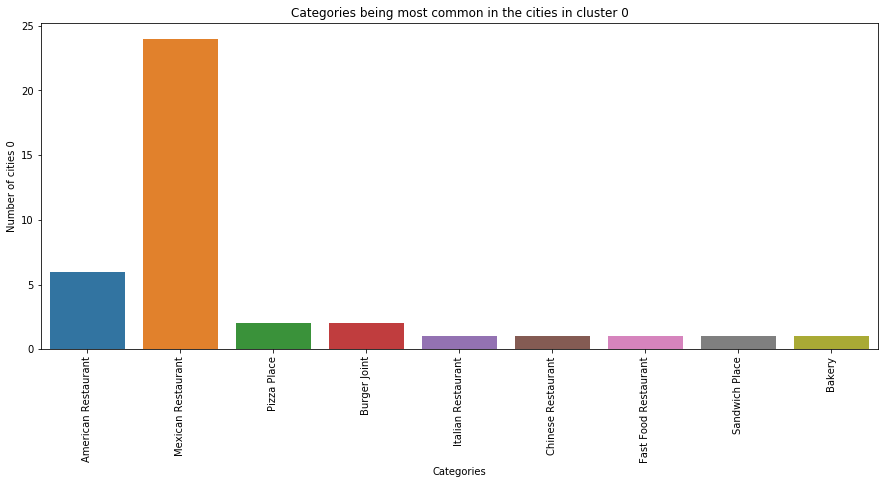

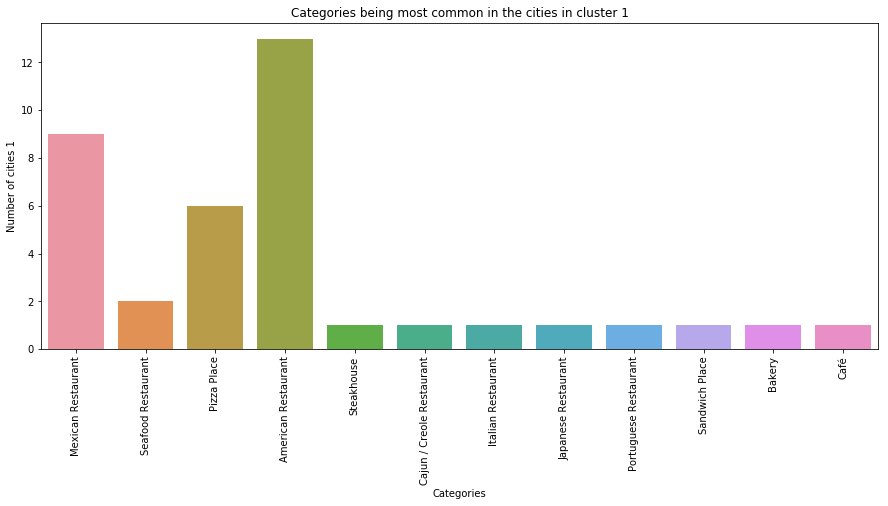

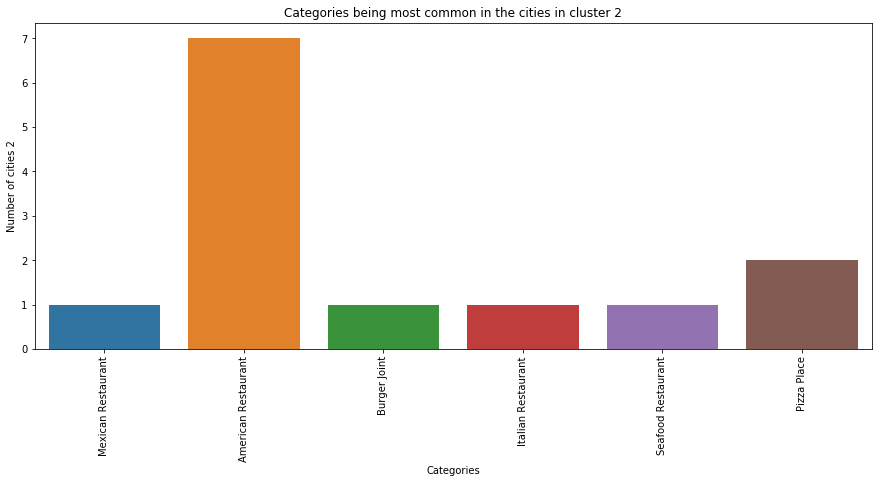

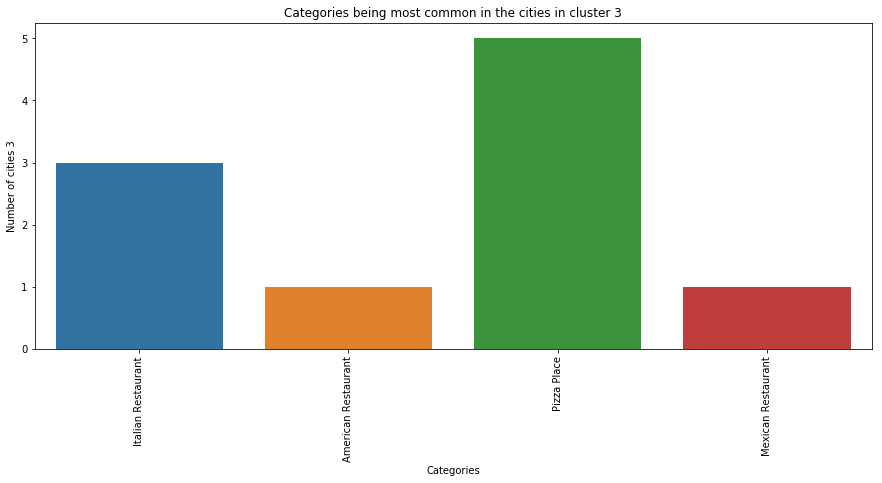

In [41]:
for i in range(nclusters):
    graphClusters(i)

#### Plotting Pie Charts of the same data

In [42]:
def pieOfClusters(cID):
    cluster_data = df_clustered.loc[df_clustered['Cluster']==cID]
    cluster_data['maxID'] = cluster_data.drop('City',axis=1).idxmax(axis=1)
    group_df = pd.DataFrame()
    for i in range(len(cluster_data)):
        type = cluster_data['maxID'].iloc[i]
        if type in group_df.columns:
            group_df[type].iloc[i] = cluster_data['City'].iloc[i]
        else:
            group_df[type] = [None]*len(cluster_data)
            group_df[type].iloc[i] = cluster_data['City'].iloc[i]
            
    count = group_df.count()
    plot = count.plot.pie(y=count, figsize=(8,8))
    plt.ylabel('cluster {}'.format(cID))
    plt.show()
    print('pie chart for cluster: {}'.format(cID))
    print('---------------------------------------')

C:\Users\Bhavya\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


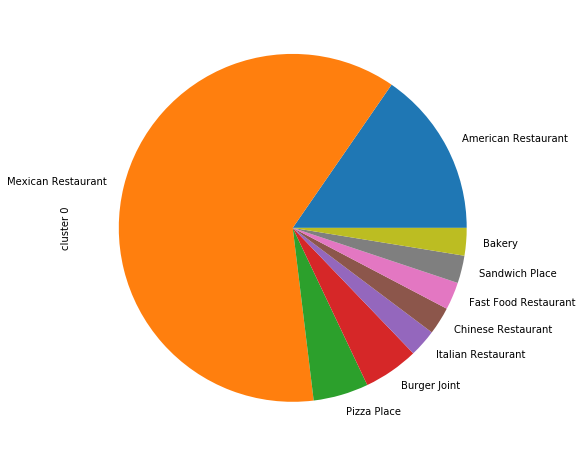

pie chart for cluster: 0
---------------------------------------


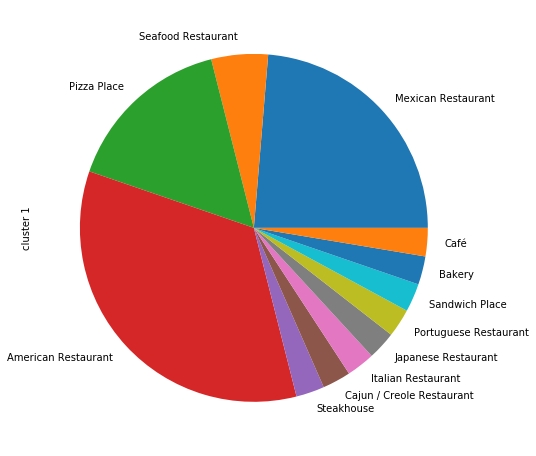

pie chart for cluster: 1
---------------------------------------


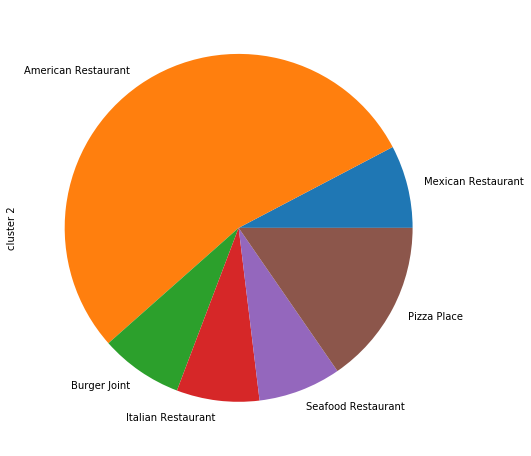

pie chart for cluster: 2
---------------------------------------


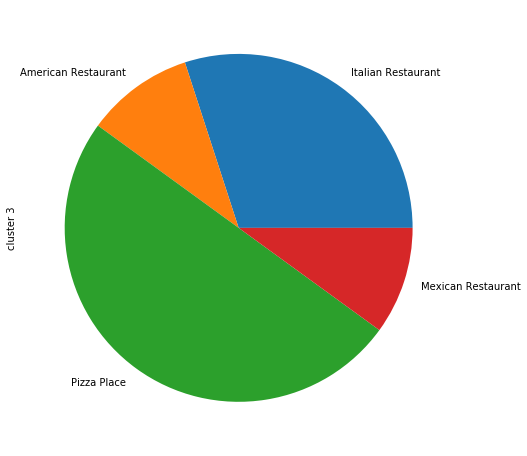

pie chart for cluster: 3
---------------------------------------


In [43]:
for i in range(nclusters):
    pieOfClusters(i)

This pie chart what a city in any given cluster will most likely to have as number one category.

Other attempts were made with different number of clusters. 4 was the ideal number of cluster for this problem. Here is the list of all the cities by clusters.

#### Listing all the cities in each cluster

In [52]:
df_x = df_clustered[['City','Cluster']]
gdf = df_x.groupby('Cluster')
for key, item in gdf:
    print('Cluster: {}'.format(key))
    print(gdf.get_group(key)['City'].tolist(), "\n\n")

Cluster: 0
['Jacksonville', 'Fort Worth', 'El Paso', 'Albuquerque', 'Tucson', 'Fresno', 'Mesa', 'Sacramento', 'Omaha', 'Tulsa', 'Arlington', 'Wichita', 'Bakersfield', 'Aurora', 'Santa Ana', 'Riverside', 'Corpus Christi', 'Lexington', 'Henderson', 'Stockton', 'Greensboro', 'Lincoln', 'Anchorage', 'Plano', 'Chula Vista', 'Toledo', 'Fort Wayne', 'Laredo', 'Chandler', 'Lubbock', 'Reno', 'Gilbert', 'North Las Vegas', 'Winston Salem', 'Chesapeake', 'Norfolk', 'Garland', 'Irving', 'Hialeah'] 


Cluster: 1
['Phoenix', 'San Antonio', 'San Diego', 'Dallas', 'San Jose', 'Austin', 'Columbus', 'Charlotte', 'Denver', 'Nashville', 'Detroit', 'Las Vegas', 'Memphis', 'Louisville', 'Baltimore', 'Milwaukee', 'Atlanta', 'Kansas City', 'Raleigh', 'Long Beach', 'Minneapolis', 'New Orleans', 'Cleveland', 'Anaheim', 'Honolulu', 'Saint Paul', 'St. Louis', 'Pittsburgh', 'Irvine', 'Newark', 'Durham', 'St. Petersburg', 'Jersey City', 'Scottsdale', 'Buffalo', 'Fremont', 'Richmond', 'Baton Rouge'] 


Cluster: 2
['H

**Map of Cites**

In [60]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [61]:
x = np.arange(nclusters)
ys = [i + x + (i*x)**2 for i in range(nclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


In [63]:
map_clusters = folium.Map(location=[37.0902, -95.7129], zoom_start=3)
markers_colors =[]

for key, item in gdf:
    cdf = gdf.get_group(key)
    for city, cluster in zip(cdf.City, cdf.Cluster):
        city_Results = getVenuesByCity(city)
        location = geolocator.geocode(city)
        Latitude, Longitude = location.latitude, location.longitude
        label = folium.Popup(city, parse_html=True)
        folium.CircleMarker(
            [Latitude, Longitude],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)

    
    
map_clusters

#### Discussions

The results concludes with 4 distinct clusters and their favourite food types.
- Cluster 0 : Most likely to prefer Mexican food
- Cluster 1 : Mix of American, Mexican and pizza places
- Cluster 2 : Overwhelmingly American
- Cluster 3 : Pizza and Italian Places, fast food places in trend

Cluster 0 has an overwhelmingly high number of mexican restaurants. If there are any additional menu to be served in this cluster, it has to include mexican style food. Apart from that there could be optional American dishes that people may prefer.

Cluster 1 has a mix of American, mexican and pizza. While mexican dishes may find a significant market here, for this cluster a focus on american dishes is needed while having a few mexican items

Cluster 2 is dominated by cities that prefer American food such as BBQ meat, pork ribs etc... It would be safe to focus primarily on american dishes here while fast food items such as pizza may or may not trend. This cluster is the default market for any food company originated in the USA serving American food.

Cluster 3 on the other hand consists of largely metropolitan cities. Here, there are so many diverse options for the food choices that several trendy categories such as pizza and italian seem to be dominating the cluster. It has the most even distribution among all the clusters with focus slightly tilted towards fast food items. People in these cities prefer food that can be served quickly and can be consumed on the go. A good idea would be to create a diverse menu with one or two fast food items from many cuisines around the world.

### Conclusions <a name='conclusion'></a>

The purpose of this project was to make groups of cities that can help determine what kind of additional menu items can be served besides the basic menu of the food chain restaurants. It does so by getting samples of food venues in the city for all the cities and making a list of the number of all the venues that appear in any category. Then the database is normalized and KMeans clustering algorithm is used to make clusters of cities. These clusters were studied and their characteristics are pointed out in this report in the discussion section.


Final decisions can be made by stakeholders and market experts based on these characteristics, trends, availability and viability. Factors such as cost of changes and potential returns in terms of increased sale can be predicted by the management and studied iteratively. In any future scenario, the results produced in this study will give key insights into the market.
